# Import the ns3 source script

In [53]:
import sys
sys.path.append("../../ns3_sem")
import sem
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
ns_path = '../../ns3-dev-hofailure_RACH'
script = 'hofailure_output'
campaign_dir = '../HOF_joiningtimeout_test'
campaign = sem.CampaignManager.new(ns_path, script, campaign_dir, overwrite=True)
print(campaign)

Building ns-3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| [00:09<00:00]


--- Campaign info ---
script: hofailure_output
params: {'simTime': 80.0, 'numberOfUes': 1.0, 'speed': 2.0, 'handoverAlgorithm': 'A3', 'Hysteresis': 3.0, 'TimeToTrigger': 256.0, 'ServingCellThreshold': 20.0, 'NeighbourCellOffset': 5.0}
HEAD: 3b9db4dd0676e2b185b796dd9273979d6d7eda0e
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


# Params

In [54]:
param_combination = {'simTime':80, 
                     'numberOfUes': 1, 
                     'speed': 2.0,#[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
                     'handoverAlgorithm': 'A3',
                     'Hysteresis':  [i * 0.1 for i in range(0, 31)], 
                     'TimeToTrigger': list([0.0, 40.0, 64.0, 80.0, 100.0, 128.0, 160.0, 256.0, 320.0, 480.0, 640.0, 1024.0, 1280.0, 2560.0, 5120.0]),
                     'ServingCellThreshold': 20, #[j * 0.5 for j in range(0, 61)],
                     'NeighbourCellOffset':1.0,
                     'RngRun': [1]
                    }

# Running the simulation with the params

In [55]:
campaign.run_missing_simulations(param_combination, stop_on_errors=False)

Running simulations: 100%|███████████████████████████████████████████████████████████████████████████████| 465/465 [11:08<00:00,  1.44s/simulation]


# Summarize the result

In [56]:
def get_average_throughput(result):
    if result['output']['stderr'] != "":
        num_HOs = -1
        num_RLFs = -1
        num_HFMRs = -1
        num_HFNPs = -1
        num_HFJs = -1
        num_HFLs = -1
    else:
        split_results = result['output']['stdout'].split("\n")
        num_HOs = 0
        num_RLFs = 0
        num_HFMRs = 0
        num_HFNPs = 0
        num_HFJs = 0
        num_HFLs = 0
        for line in split_results:
            event = line.split(":")[0]
            if event == "HO_start":
                num_HOs += 1
            elif event == "RLF_detected":
                num_RLFs += 1
            elif event == "HO_Failure_NoPreamble":
                num_HFNPs += 1
            elif event == "HO_Failure_JoiningTimeout":
                num_HFJs += 1
            elif event == "HO_Failure_MaxRach":
                num_HFMRs += 1
            elif event == "HO_Failure_Leaving":
                num_HFLs += 1
    return [num_HOs, num_RLFs, num_HFNPs, num_HFJs, num_HFMRs, num_HFLs]

# Generate dataframe of the result

In [57]:
results = campaign.get_results_as_dataframe(get_average_throughput, 
                                            ['num_HOs', 'num_RLFs','num_HFNPs','num_HFJs','num_HFMRs','num_HFLs'], 
                                            params = param_combination, drop_constant_columns=True)
print(results)

     Hysteresis  TimeToTrigger  num_HOs  num_RLFs  num_HFJs
0           0.0            0.0        4         0         0
1           0.0           40.0        4         0         0
2           0.0           64.0        4         0         0
3           0.0           80.0        4         0         0
4           0.0          100.0        4         0         0
..          ...            ...      ...       ...       ...
460         3.0          640.0        4         0         4
461         3.0         1024.0        2         3         2
462         3.0         1280.0        1         3         1
463         3.0         2560.0        0         4         0
464         3.0         5120.0        0         4         0

[465 rows x 5 columns]


# Plot the result

Text(0.5, 1.0, 'Number of HOs, RLFs, HFNPs, HFJs (TimeToTrigger = 256 ms, speed = 10 m/s)')

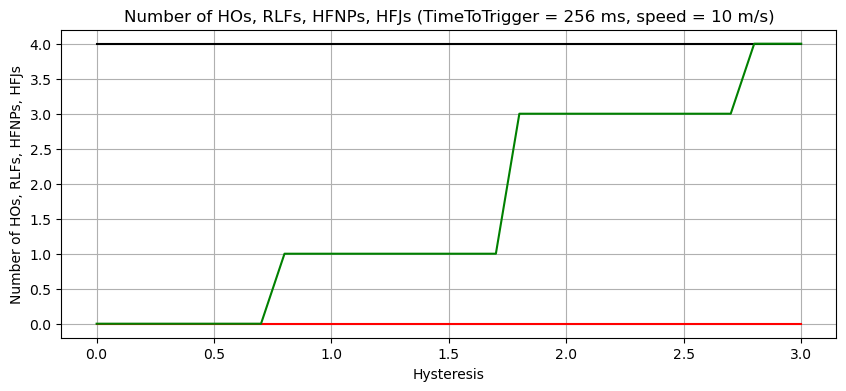

In [60]:
results_Hys = results[#(results['speed'] == 5.0), 
                      (results['TimeToTrigger'] == 100.0)]
#results[(results['NeighbourCellOffset'] == 0.5)]
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(results_Hys['Hysteresis'], results_Hys['num_HOs'], color = 'black')
ax.plot(results_Hys['Hysteresis'], results_Hys['num_RLFs'], color = 'red')
ax.plot(results_Hys['Hysteresis'], results_Hys['num_HFJs'], color = 'green')
#ax.plot(results_Hys['Hysteresis'], results_Hys['Num_HFNPs'], color = 'blue')
ax.grid()
ax.set_xlabel('Hysteresis')
ax.set_ylabel('Number of HOs, RLFs, HFNPs, HFJs')
ax.set_title('Number of HOs, RLFs, HFNPs, HFJs (TimeToTrigger = 256 ms, speed = 10 m/s)')
#ax.legend(['Num_HOs', 'Num_RLFs','Num_HFJs'])#'Num_HFNPs'